# Searching for and retrieving images

In this notebook, we show how to search for and retrieve images from VO services using the Registry and the __[Simple Image Access](http://www.ivoa.net/documents/SIA/)__ (SIA) protocol.

* [1. Finding](#finding) SIA resources from the Registry
* [2. Using](#sia) SIA to retrieve an image



####  (Note:  for all of these notebooks, the results depend on real-time queries.  Sometimes there are problems, either because a given service has changed, is undergoing maintenance, or the internet connectivity is having problems, etc.  Always retry a couple of times, come back later and try again, and only then send us the problem report to investigate.)

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import astropy
from IPython.display import Image as ipImage, display

# NAVO utilities
from navo_utils.image import Image, ImageColumn
from navo_utils.registry import Registry

# For handling ordinary astropy Tables
from astropy.table import Table

# For reading FITS files
import astropy.io.fits as apfits

# Surpress known innocuous warnings
import warnings
warnings.filterwarnings("ignore", module="astropy.io.votable.*")
warnings.filterwarnings('ignore', message='\n*.*axes_grid module was deprecated.*',)

# For pretty displays
import aplpy


<a id="finding"></a>

# 1.  Finding SIA resources from the Registry

First, how do we find out what  services are available?  These are listed in a registry at STScI (__[see here](http://vao.stsci.edu/keyword-search/)__).  Our Registry function gives a simple interface for how to search for services.  

Let's search for services providing images in the ultraviolet bands:

In [2]:
uv_tables=Registry.query(service_type='image',waveband='uv')
## Sometimes strange behavior with this now
uv_tables.show_in_notebook()
#uv_tables
#uv_tables.info

idx,waveband,short_name,ivoid,res_description,access_url,reference_url,publisher,service_type
0,uv,GALEX,ivo://nasa.heasarc/skyview/galex,"The GALEX, Galaxy Explorer, mission was launched by a Pegasus-XL vehicle on April 28 2003 into a 690km altitude, 29 degree inclination, circular orbit with a 98.6 minute period. The GALEX instrument allows imaging and spectroscopic observations to be made in two ultraviolet bands, Far UV (FUV) 1350-1780A and Near UV (NUV) 1770-2730A. The instrument provides simultaneous co-aligned FUV and NUV images with spatial resolution 4.3 and 5.3 arcseconds respectively. Details of the performance of the instrument and detectors can be found in Morrissey et al. (2007) ApJS, 173, 682. &amp;lt;p&amp;gt; The &amp;lt;i&amp;gt;SkyView&amp;lt;/i&amp;gt; GALEX surveys mosaic the intensity images of All-Sky Survey images. For a given pixel only the nearest image is used. Since a given GALEX observation is circular, this maximizes the coverage compared with default image finding algorithms which use the distance from edge of the image. &amp;lt;p&amp;gt; As of February 10, 2011, SkyView uses the GALEX GR6 data release.",https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=galex&amp;,https://skyview.gsfc.nasa.gov,NASA/GSFC HEASARC,simpleimageaccess
1,optical#infrared#uv,HST PR Images,ivo://mast.stsci/stpr,"The MAST Hubble Space Telescope Press Release Image Archive contains TIFF and JPEG images released between 2008 and 2010. In most cases, images have been coadded/mosaiced from data taken in different bandpasses and at various observation times, so some metadata values may not be accurate. In general, images are for display and not for scientific analysis.",http://archive.stsci.edu/stpr/vo_search.php?,http://archive.stsci.edu/stpr/search.php/,Space Telescope Science Institute Archive,simpleimageaccess
2,infrared#optical#uv#euv,MAST-Scrapbook,ivo://irsa.ipac/mast/scrapbook,The MAST Spectral/Image Scrapbook is designed to allow users to take a quick look at sample data in the MAST archive of a particular astronomical object of interest. It is set up here as an interoperability project between IRSA and MAST.,https://irsa.ipac.caltech.edu/cgi-bin/Atlas/nph-atlas?mission=Scrapbook&amp;hdr_location=%5CScrapbookDataPath%5C&amp;collection_desc=The+MAST+Image%2FSpectra+Scrapbook+%28Scrapbook%29&amp;SIAP_ACTIVE=1&amp;,https://irsa.ipac.caltech.edu/data/Scrapbook,NASA/IPAC Infrared Science Archive,simpleimageaccess
3,uv,GALEX,ivo://archive.stsci.edu/sia/galex,"The Galaxy Evolution Explorer (GALEX), a NASA Small Explorer mission, is performing the first all-sky, deep imaging and spectroscopic ultraviolet surveys in space. The prime goal of GALEX is to study star formation in galaxies and its evolution with time.",https://mast.stsci.edu/portal/Mashup/VoQuery.asmx/SiaV1?MISSION=GALEX&amp;,http://galex.stsci.edu,Space Telescope Science Institute,simpleimageaccess
4,uv,UIT,ivo://mast.stsci/siap/uit,"The Ultraviolet Imaging Telescope UIT was one of three ultraviolet telescopes on the ASTRO-1 mission flown on the space shuttle Columbia during 2-10 December 1990. The same three instruments were later flown on the space shuttle Endeavour from 3-17 March 1995, as part of the ASTRO-2 mission. Exposures were obtained on 70-mm photographic film in the 1200-3300 Å range using broadband filters and later digitized using a Perkin-Elmer microdensitometer. Image resolution was 3"" over a 40' field of view. Overall, UIT-1 obtained 821 exposures of 66 targets, and UIT-2 obtained 758 images of 193 targets.",http://archive.stsci.edu/siap/search.php?id=UIT&amp;,http://archive.stsci.edu/uit/,Space Telescope Science Institute Archive,simpleimageaccess
5,optical#uv,HST.ANGRRR,ivo://mast.stsci/angrrr,"An archive of stellar photometry for galaxies within 3.5 Mpc, excluding Local Group galaxies, based on primary and parallel wide-filter UV and optical observations taken with HST ACS/WFC or WFPC2.The sample includes all observations taken through Dec

This returns an astropy table containing information about the services available.  We can then specify the service we want by using the "access_url" entry in the corresponding row.  We'll repeat the search with additional qualifiers to isolate the row we want:

In [3]:
## In the keyword search, the "%" character is a wild card.
uv_tables=Registry.query(service_type='image',waveband='uv',keyword='swiftuvot')
uv_tables

<Table masked=True length=1>
 waveband  short_name ...     publisher        service_type  
  str10       str9    ...       str17             str17      
---------- ---------- ... ----------------- -----------------
uv#optical  SWIFTUVOT ... NASA/GSFC HEASARC simpleimageaccess

This shows us that the data we are interested in comes from the HEASARC's SkyView service, but the point of these VO tools is that you don't need to know that ahead of time or indeed to care where it comes from.

<a id="sia"></a>

# 2. Using SIA to retrieve an image:

Now we look for images of our favorite source.  See __[the SIA definition](http://www.ivoa.net/documents/WD/SIA/sia-20040524.html)__ for usage.  In short, you can specify the central position (POS), the angular SIZE, and the NAXIS, i.e., the number of bins.  It is up to the service to determine how to provide this.  SkyView, for example, will mosaic/bin/interpolate as needed from the archive data.

What is returned to you is not the image itself but a list of images available and how to access them.  This is easiest shown by example:  

In [4]:
pos='202.469575,47.195258'
im_table=Image.query(service=uv_tables[0],coords=pos,radius=0.2)
im_table[0]

Survey,Ra,Dec,Dim,Size,Scale,Format,PixFlags,URL,LogicalName
str16,float64,float64,int32,object,object,str10,str1,str272,str1
swiftuvotvint,202.469575,47.1952583,2,[300 300],[-0.0013333333333333335 0.0013333333333333335],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.1952583&survey=swiftuvotvint&pixels=300%2C300&sampler=LI&size=0.4000000000000001%2C0.4000000000000001&projection=Tan&coordinates=J2000.0&requestID=skv1544830388268&return=FITS,1
swiftuvotvint,202.469575,47.1952583,2,[300 300],[-0.0013333333333333335 0.0013333333333333335],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.1952583&survey=swiftuvotvint&pixels=300%2C300&sampler=LI&size=0.4000000000000001%2C0.4000000000000001&projection=Tan&coordinates=J2000.0&requestID=skv1544830388268&nofits=1&quicklook=jpeg&return=jpeg,1
swiftuvotbint,202.469575,47.1952583,2,[300 300],[-0.0013333333333333335 0.0013333333333333335],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.1952583&survey=swiftuvotbint&pixels=300%2C300&sampler=LI&size=0.4000000000000001%2C0.4000000000000001&projection=Tan&coordinates=J2000.0&requestID=skv1544830388977&return=FITS,2
swiftuvotbint,202.469575,47.1952583,2,[300 300],[-0.0013333333333333335 0.0013333333333333335],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.1952583&survey=swiftuvotbint&pixels=300%2C300&sampler=LI&size=0.4000000000000001%2C0.4000000000000001&projection=Tan&coordinates=J2000.0&requestID=skv1544830388977&nofits=1&quicklook=jpeg&return=jpeg,2
swiftuvotuint,202.469575,47.1952583,2,[300 300],[-0.0013333333333333335 0.0013333333333333335],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.1952583&survey=swiftuvotuint&pixels=300%2C300&sampler=LI&size=0.4000000000000001%2C0.4000000000000001&projection=Tan&coordinates=J2000.0&requestID=skv1544830390429&return=FITS,3
swiftuvotuint,202.469575,47.1952583,2,[300 300],[-0.0013333333333333335 0.0013333333333333335],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.1952583&survey=swiftuvotuint&pixels=300%2C300&sampler=LI&size=0.4000000000000001%2C0.4000000000000001&projection=Tan&coordinates=J2000.0&requestID=skv1544830390429&nofits=1&quicklook=jpeg&return=jpeg,3
swiftuvotuvw1int,202.469575,47.1952583,2,[300 300],[-0.0013333333333333335 0.0013333333333333335],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.1952583&survey=swiftuvotuvw1int&pixels=300%2C300&sampler=LI&size=0.4000000000000001%2C0.4000000000000001&projection=Tan&coordinates=J2000.0&requestID=skv1544830392139&return=FITS,4
swiftuvotuvw1int,202.469575,47.1952583,2,[300 300],[-0.0013333333333333335 0.0013333333333333335],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.1952583&survey=swiftuvotuvw1int&pixels=300%2C300&sampler=LI&size=0.4000000000000001%2C0.4000000000000001&projection=Tan&coordinates=J2000.0&requestID=skv1544830392139&nofits=1&quicklook=jpeg&return=jpeg,4
swiftuvotuvw2int,202.469575,47.1952583,2,[300 300],[-0.0013333333333333335 0.0013333333333333335],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.1952583&survey=swiftuvotuvw2int&pixels=300%2C300&sampler=LI&size=0.4000000000000001%2C0.4000000000000001&projection=Tan&coordinates=J2000.0&requestID=skv1544830393971&return=FITS,5


Extract the fields you're interested in, e.g., the URLs of the images made by skyview.  Note that specifying as we did SwiftUVOT, we get a number of different images, e.g., UVOT U, V, B, W1, W2, etc.  For each survey, there are two URLs, first the FITS IMAGE and second the JPEG.  

Note that different services will return different column names, but all will have a column giving the URL to access the image.  The ImageColumn class can be used to extract the correct column without having to know what the individual services call it;  you can always ask for the column given by ImageColumn.ACCESS_URL.

In [5]:
row_fits=0 # You see above that even-numbered rows are the JPEGs, the next the corresponding FITS
row_jpeg=row_fits+1
###  Inside the table is a numpy record array that you can access like this, for example:
###  (for the 0th object result, the 7th row, the 8th column)
#print(table.array[0][7][8])
#  Or like this
print(im_table[0][row_fits][ImageColumn.ACCESS_URL])
### To download the FITS image itself:
print(im_table[0][row_jpeg][ImageColumn.ACCESS_URL])

https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.1952583&survey=swiftuvotvint&pixels=300%2C300&sampler=LI&size=0.4000000000000001%2C0.4000000000000001&projection=Tan&coordinates=J2000.0&requestID=skv1544830388268&return=FITS
https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.1952583&survey=swiftuvotvint&pixels=300%2C300&sampler=LI&size=0.4000000000000001%2C0.4000000000000001&projection=Tan&coordinates=J2000.0&requestID=skv1544830388268&nofits=1&quicklook=jpeg&return=jpeg


### Resulting image
Since we can see that the second row is a JPEG, we can display it in python easily.

Again, we can use the ImageColumn utility to check the format.  Whatever the service calls the format column, We can check it with ImageColumn.FORMAT.  


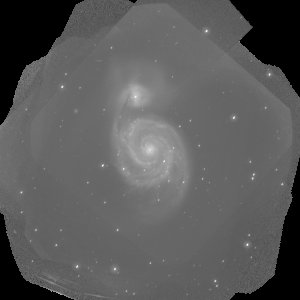

In [6]:
if (im_table[0][row_jpeg][ImageColumn.FORMAT] == "image/jpeg"):
    display(Image.get_image(im_table[0][row_jpeg]))

Or download the FITS image and display it with:

(This often errors off with a time out message.  Just try it again, possibly a couple of times.)

In [7]:
hdu_list=Image.get_fits(im_table[0][row_fits])

In [8]:
im_table[0][row_fits]

Survey,Ra,Dec,Dim,Size,Scale,Format,PixFlags,URL,LogicalName
str16,float64,float64,int32,object,object,str10,str1,str272,str1
swiftuvotvint,202.469575,47.1952583,2,[300 300],[-0.0013333333333333335 0.0013333333333333335],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.469575%2C47.1952583&survey=swiftuvotvint&pixels=300%2C300&sampler=LI&size=0.4000000000000001%2C0.4000000000000001&projection=Tan&coordinates=J2000.0&requestID=skv1544830388268&return=FITS,1


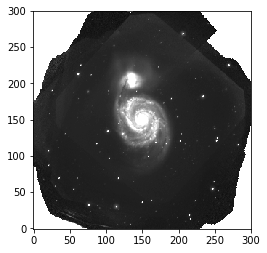

In [9]:
plt.imshow(hdu_list[0].data, cmap='gray', origin='lower',vmax=0.1)

### Now with aplpy

This package knows how to read the header keywords in WCS to display the correct coordinate axes.  

INFO: Auto-setting vmin to  7.026e-03 [aplpy.core]


/Users/donald/anaconda/envs/navo/lib/python3.6/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


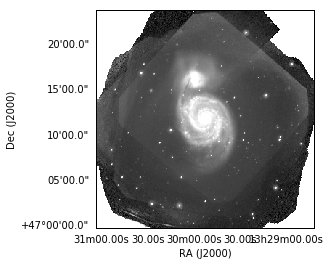

In [10]:
gc = aplpy.FITSFigure(hdu_list,figsize=(4, 4))
gc.show_grayscale(stretch='log', vmax=0.1)

### A related example with several services offering the same data:
Suppose we want SDSS data.  A generic query finds us a number of possibilities:

In [11]:
cat_table=Registry.query(service_type='image',keyword='sdss',waveband='optical')
cat_table

waveband,short_name,ivoid,res_description,access_url,reference_url,publisher,service_type
str7,str13,str38,str630,str105,str29,str28,str17
optical,SDSSDR2,ivo://sdss.jhu/services/siapdr2-images,"The Sloan Digital Sky Survey is a project to survey a 10000 square degree area on the Northern sky over a 5 year period. A dedicated 2.5m telescope is specially designed to take wide field (3 degrees in diameter) images using a 5x6 mosaic of 2048x2048 CCD`s, in five wavelength bands, operating in drift scan mode. The total raw data will exceed 40 TB. A processed subset, of about 1 TB in size, will consist of 1 million spectra, positions and image parameters for over 100 million objects, plus a mini-image centered on each object in every color. The data will be made available to the public after the completion of the survey",http://skyserver.sdss.org/vo/DR2SIAP/SIAP.asmx/getSiapInfo?&amp;FORMAT=image/fits&amp;BANDPASS=ugriz&amp;,http://www.sdss.jhu.edu/,The Johns Hopkins University,simpleimageaccess
optical,SDSSDR1,ivo://sdss.jhu/services/siapdr1-images,"The Sloan Digital Sky Survey is a project to survey a 10000 square degree area on the Northern sky over a 5 year period. A dedicated 2.5m telescope is specially designed to take wide field (3 degrees in diameter) images using a 5x6 mosaic of 2048x2048 CCD`s, in five wavelength bands, operating in drift scan mode. The total raw data will exceed 40 TB. A processed subset, of about 1 TB in size, will consist of 1 million spectra, positions and image parameters for over 100 million objects, plus a mini-image centered on each object in every color. The data will be made available to the public after the completion of the survey",http://skyserver.sdss.org/vo/DR1SIAP/SIAP.asmx/getSiapInfo?&amp;FORMAT=image/fits&amp;BANDPASS=ugriz&amp;,http://www.sdss.jhu.edu/,The Johns Hopkins University,simpleimageaccess
optical,SDSSDR7,ivo://sdss.jhu/services/siapdr7-images,"The Sloan Digital Sky Survey is a project to survey a 10000 square degree area on the Northern sky over a 5 year period. A dedicated 2.5m telescope is specially designed to take wide field (3 degrees in diameter) images using a 5x6 mosaic of 2048x2048 CCD`s, in five wavelength bands, operating in drift scan mode. The total raw data will exceed 40 TB. A processed subset, of about 1 TB in size, will consist of 1 million spectra, positions and image parameters for over 100 million objects, plus a mini-image centered on each object in every color. The data will be made available to the public after the completion of the survey",http://skyserver.sdss.org/vo/DR7SIAP/SIAP.asmx/getSiapInfo?&amp;FORMAT=image/fits&amp;BANDPASS=ugriz&amp;,http://www.sdss.jhu.edu/,The Johns Hopkins University,simpleimageaccess
optical,SDSSDR8,ivo://sdss.jhu/services/siapdr8-images,"The Sloan Digital Sky Survey is a project to survey a 10000 square degree area on the Northern sky over a 5 year period. A dedicated 2.5m telescope is specially designed to take wide field (3 degrees in diameter) images using a 5x6 mosaic of 2048x2048 CCD`s, in five wavelength bands, operating in drift scan mode. The total raw data will exceed 40 TB. A processed subset, of about 1 TB in size, will consist of 1 million spectra, positions and image parameters for over 100 million objects, plus a mini-image centered on each object in every color. The data will be made available to the public after the completion of the survey",http://skyserver.sdss.org/vo/DR8SIAP/SIAP.asmx/getSiapInfo?&amp;FORMAT=image/fits&amp;BANDPASS=ugriz&amp;,http://www.sdss.jhu.edu/,The Johns Hopkins University,simpleimageaccess
optical,SDSSDR9,ivo://sdss.jhu/services/siapdr9-images,"The Sloan Digital Sky Survey is a project to survey a 10000 square degree area on the Northern sky over a 5 year period. A dedicated 2.5m telescope is specially designed to take wide field (3 degrees in diameter) images using a 5x6 mosaic of 2048x2048 CCD`s, in five wavelength bands, operating in drift scan mode. The total raw data will ex

In [12]:
#  numpy makes it easy to select the rows of a table where a column has a given value:  
cat_dr7 = cat_table[np.isin(cat_table['short_name'], 
                                    ['SDSSDR7'])]
cat_dr7['short_name', 'access_url']

short_name,access_url
str13,str105
SDSSDR7,http://skyserver.sdss.org/vo/DR7SIAP/SIAP.asmx/getSiapInfo?&amp;FORMAT=image/fits&amp;BANDPASS=ugriz&amp;
SDSSDR7,https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=sdssdr7&amp;


In [13]:
sdss_table=Image.query(cat_dr7[0],coords=pos,radius=0.1)
sdss_table[0]

Title,width,height,size,RA,DEC,scale,format,url,equinox,naxes,naxis,crtype,crpix,crval,cdval
str35,int32,int32,float64,float64,float64,object,str10,str68,float64,int32,object,str16,object,object,object
Sloan Digital Sky Survey - Filter u,2048,1489,3049472.0,202.439715840115,47.1222952774076,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3699/41/corr/6/fpC-003699-u6-0100.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.439715840115 47.1222952774076],[3.57829352076884e-05 0.000157654334590212 0.000107291403325821 -2.42761847386219e-05]
Sloan Digital Sky Survey - Filter g,2048,1489,3049472.0,202.438763451233,47.1224982411069,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3699/41/corr/6/fpC-003699-g6-0100.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.438763451233 47.1224982411069],[3.57455198349534e-05 0.000157658871914506 0.000107248674325512 -2.4298297148212e-05]
Sloan Digital Sky Survey - Filter r,2048,1489,3049472.0,202.440760551524,47.1223224530134,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3699/41/corr/6/fpC-003699-r6-0100.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.440760551524 47.1223224530134],[3.57284422970295e-05 0.000157658504949188 0.000107285884319316 -2.43020165047957e-05]
Sloan Digital Sky Survey - Filter i,2048,1489,3049472.0,202.440280828514,47.1221470640024,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3699/41/corr/6/fpC-003699-i6-0100.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.440280828514 47.1221470640024],[3.57634273620044e-05 0.00015761708892598 0.000107330126376146 -2.43196618936367e-05]
Sloan Digital Sky Survey - Filter z,2048,1489,3049472.0,202.439529079822,47.1222577816612,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3699/41/corr/6/fpC-003699-z6-0100.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.439529079822 47.1222577816612],[3.57150015372814e-05 0.000157643765195985 0.000107288170305585 -2.43520424844304e-05]
Sloan Digital Sky Survey - Filter u,2048,1489,3049472.0,202.471051455651,47.3353076054504,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3716/42/corr/6/fpC-003716-u6-0117.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.471051455651 47.3353076054504],[3.59720233632108e-05 0.000158234026889022 0.000107269639460545 -2.43685414700374e-05]
Sloan Digital Sky Survey - Filter g,2048,1489,3049472.0,202.470063167219,47.3355466663192,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3716/42/corr/6/fpC-003716-g6-0117.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.470063167219 47.3355466663192],[3.59432847686782e-05 0.000158250992709564 0.000107232188959642 -2.43648103577398e-05]
Sloan Digital Sky Survey - Filter r,2048,1489,3049472.0,202.472135546076,47.3353955051599,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3716/42/corr/6/fpC-003716-r6-0117.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.472135546076 47.3353955051599],[3.59415181020478e-05 0.000158248434019201 0.000107267969211639 -2.43568204128413e-05]
Sloan Digital Sky Survey - Filter i,2048,1489,3049472.0,202.471591570338,47.3352202087437,[0.000110035211267606],image/fits,http://das.sdss.org/imaging/3716/42/corr/6/fpC-003716-i6-0117.fit.gz,--,2,[2048 1489],"RA--TAN,DEC--TAN",[744.5 1024.5],[202.471591570338 47.3352202087437],[3.59688512209066e-05 0.000158230937820391 0.000107320614280034 -2.43668898148645e-05]


So one of these is served by SDSS's SkyServer and the other by HEASARC's SkyView.  The SIA service at SkyServer returns the following image:

FITS image written to downloads/sdssdr7_image.fits



the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


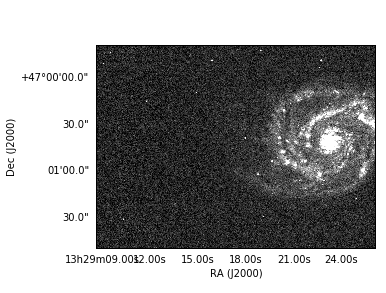

In [14]:
pos='202.469575,47.195258'
sdss_table=Image.query(cat_dr7[0],coords=pos,radius=0.1)
#  Download the FITS image:
Image.get_fits(sdss_table[0][0],filename='downloads/sdssdr7_image.fits')
hdu_list=apfits.open('downloads/sdssdr7_image.fits')
gc = aplpy.FITSFigure(hdu_list,figsize=(5, 5))
gc.show_grayscale(stretch='log', vmax=1050,vmin=1010)
#plt.imshow(hdu_list[0].data, cmap='gray', origin='lower',vmax=1100,vmin=1010) #040,vmin=1000)

In [15]:
#import pdb; pdb.set_trace()
sdss_table=Image.query(cat_dr7[0],coords=pos,radius=0.1)

The SkyView service returns this one processed slightly differently:

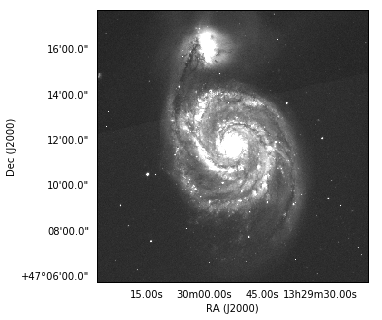

In [16]:
sv_table=Image.query(cat_dr7[1],coords=pos,radius=0.1)
gc=aplpy.FITSFigure( Image.get_fits(sv_table[0][0]), figsize=(5,5) )
gc.show_grayscale(stretch='log', vmax=1300,vmin=1010)

But it turns out that SkyView is just getting it by using the SIAP internally to get the data from the SDSS service.  The point of the VO protocols is that you don't need to know where the data are coming from.  